In [117]:
import pandas as pd
import optuna
from optuna.pruners import MedianPruner
from optuna.integration import XGBoostPruningCallback
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [118]:
# Define objective function for Optuna optimization
def rf_objective(trial):
    # Hyperparameters to be optimized
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 5, 50, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    
    model = RandomForestRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )
    
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    
    return rmse

In [119]:
# Load dataset
df = pd.read_csv('test-data/2015_to_2022_dataset.csv',parse_dates=["Date"])

In [120]:
# Replace missing values with NaN
df.replace("", np.nan, inplace=True)

In [121]:
df.isnull().sum()

Code                         0
Locale                       0
Date                         0
Temperature                  7
Precipitation            63134
Wind_Speed                  55
Wind_Direction              68
Humidity                    35
Vapor_Pressure               7
Dew_Point_Temperature       10
Spot_Atm_Pressure           21
Sea_Level_Pressure          17
Daylight_Time            32027
Insolation               31852
Snowfall_Amount          68051
Clouds_Amount             7111
Ground_Temperature          67
SO2                       1486
CO                        2672
NO2                       2074
PM10                      1436
PM2_5                     1330
O3                        1397
dtype: int64

In [122]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.strftime('%y%m%d%H')
df['Date'] = df['Date'].astype(int)

df['Year'] = df['Date'].apply(lambda x: 2000 + int(str(x)[:2]))  # Adding 2000 to get the full year, e.g., 2015
df['Month'] = df['Date'].apply(lambda x: int(str(x)[2:4]))
df['Day'] = df['Date'].apply(lambda x: int(str(x)[4:6]))
df['Hour'] = df['Date'].apply(lambda x: int(str(x)[6:]))

In [124]:
df

,Code,Locale,Date,Temperature,Precipitation,Wind_Speed,Wind_Direction,Humidity,Vapor_Pressure,Dew_Point_Temperature,...,SO2,CO,NO2,PM10,PM2_5,O3,Year,Month,Day,Hour
0,108,Seoul,15010100,NaN,NaN,6.1,290.0,NaN,NaN,NaN,...,0.006,0.6,0.011,46.0,NaN,0.022,2015,1,1,0
1,108,Seoul,15010101,-7.4,NaN,4.7,290.0,33.0,1.2,-20.9,...,0.006,0.6,0.011,44.0,7.0,0.022,2015,1,1,1
2,108,Seoul,15010102,-8.0,NaN,4.5,290.0,35.0,1.2,-20.8,...,0.006,0.6,0.010,57.0,10.0,0.022,2015,1,1,2
3,108,Seoul,15010103,-8.4,NaN,3.8,290.0,37.0,1.2,-20.5,...,0.006,0.6,0.010,76.0,10.0,0.021,2015,1,1,3
4,108,Seoul,15010104,-8.8,NaN,4.9,290.0,35.0,1.1,-21.5,...,0.006,0.6,0.009,86.0,11.0,0.022,2015,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70123,108,Seoul,22123119,-0.2,NaN,1.8,20.0,73.0,4.4,-4.4,...,0.004,1.1,0.064,65.0,59.0,0.004,2022,12,31,19
70124,108,Seoul,22123120,-0.8,NaN,1.4,20.0,75.0,4.3,-4.6,...,0.005,1.2,0.065,69.0,59.0,0.004,2022,12,31,20
70125,108,Seoul,22123121,-1.0,NaN,0.9,340.0,77.0,4.4,-4.5,...,0.004,1.3,0.066,67.0,62.0,0.004,2022,12,31,21
70126,108,Seoul,22123122,-0.8,NaN,0.5,290.0,78.0,4.5,-4.1,...,0.004,1.3,0.066,63.0,62.0,0.004,2022,12,31,22


In [125]:
# Define the columns to be imputed with the median
median_columns = [
    'Temperature', 'Wind_Speed', 'Wind_Direction', 'Humidity',
    'Vapor_Pressure', 'Dew_Point_Temperature', 'Spot_Atm_Pressure',
    'Sea_Level_Pressure', 'SO2', 'CO', 'NO2', 'PM10', 'PM2_5', 'O3',
    'Ground_Temperature'
]

# Define the columns to be imputed with zero
zeroing_columns = [
    'Precipitation', 'Daylight_Time', 'Insolation',
    'Snowfall_Amount', 'Clouds_Amount'
]

# Create imputer for median
imputer_median = SimpleImputer(strategy='median')

# Apply the imputer to the columns that require the median
df[median_columns] = imputer_median.fit_transform(df[median_columns])

# Fill the NaN values with zero for the columns that require zeroing
df[zeroing_columns] = df[zeroing_columns].fillna(0)

# Check if there are any remaining NaN values
print(df.isnull().sum())

Code                     0
Locale                   0
Date                     0
Temperature              0
Precipitation            0
Wind_Speed               0
Wind_Direction           0
Humidity                 0
Vapor_Pressure           0
Dew_Point_Temperature    0
Spot_Atm_Pressure        0
Sea_Level_Pressure       0
Daylight_Time            0
Insolation               0
Snowfall_Amount          0
Clouds_Amount            0
Ground_Temperature       0
SO2                      0
CO                       0
NO2                      0
PM10                     0
PM2_5                    0
O3                       0
Year                     0
Month                    0
Day                      0
Hour                     0
dtype: int64


In [126]:
df = df.drop(columns = ['Code','Date', 'Locale'])

In [106]:
df = df.drop(columns = ['NO2','SO2', 'CO','PM10','PM2_5'])

<AxesSubplot:>

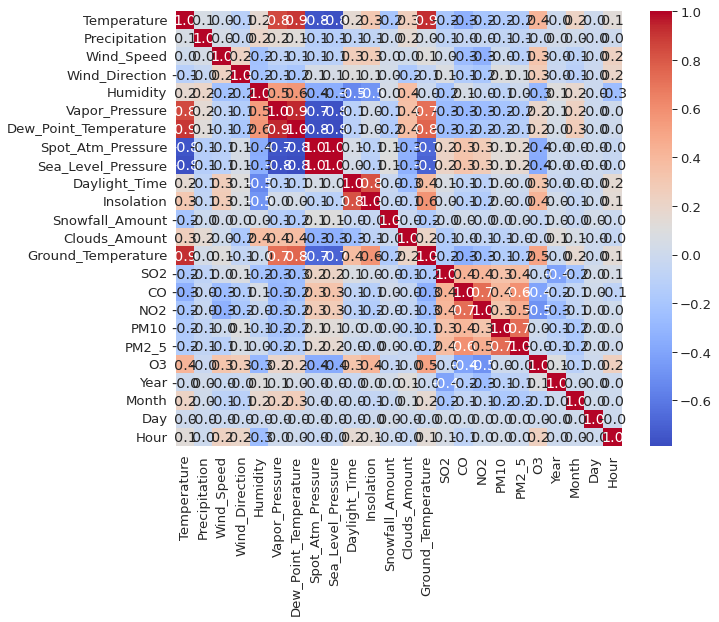

In [127]:
corr = df.corr()

sns.set_style('whitegrid')

sns.set_context('paper', font_scale=1.5)
plt.figure(figsize=(10, 8)) 
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.1f')

In [128]:
# Specify the target variable
y = df['O3']

In [129]:
# Specify the feature variables
X = df.drop(['O3'], axis=1)

In [130]:
# Feature Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [131]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Define the hyperparameters grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters: ", grid_search.best_params_)

# Initialize Random Forest Regressor with the best parameters
model = grid_search.best_estimator_

# Fit the model
model.fit(X_train, y_train)

In [132]:
# Create a study object and specify the direction is 'minimize'.
study = optuna.create_study(direction='minimize')

# Optimize the study, the objective function is passed in as the first argument.
study.optimize(rf_objective, n_trials=100)

# Results
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Best parameters
best_params = trial.params
model = RandomForestRegressor(**best_params)
model.fit(X_train, y_train)  # Train final model with best parameters

[I 2023-08-18 15:18:52,648] A new study created in memory with name: no-name-e2b2893e-e576-4d48-885c-ec8f7c94fd29
[I 2023-08-18 15:18:53,817] Trial 0 finished with value: 0.00892597208163303 and parameters: {'n_estimators': 86, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.00892597208163303.
[I 2023-08-18 15:18:55,881] Trial 1 finished with value: 0.00683051107451999 and parameters: {'n_estimators': 108, 'max_depth': 38, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.00683051107451999.
[I 2023-08-18 15:18:58,471] Trial 2 finished with value: 0.006976601148187259 and parameters: {'n_estimators': 162, 'max_depth': 45, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.00683051107451999.
[I 2023-08-18 15:19:00,094] Trial 3 finished with value: 0.010098009096135849 and parameters: {'n_estimators': 169, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 1 with

Best trial:
  Value: 0.006710314104608289
  Params: 
    n_estimators: 198
    max_depth: 30
    min_samples_split: 2
    min_samples_leaf: 1


RandomForestRegressor(max_depth=30, n_estimators=198)

In [204]:
optuna.visualization.plot_optimization_history(study)

In [205]:
optuna.visualization.plot_param_importances(study)

In [206]:
optuna.visualization.plot_slice(study)

In [207]:
optuna.visualization.plot_contour(study, params=['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf'])


In [134]:
optuna.visualization.plot_intermediate_values(study)

[W 2023-08-18 13:16:54,735] You need to set up the pruning feature to utilize `plot_intermediate_values()`


In [135]:
optuna.visualization.plot_parallel_coordinate(study)
#optuna.visualization.plot_edf([study1, study2])

In [133]:
# Make predictions
predictions = model.predict(X_test)

In [134]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("RMSE: %f" % (rmse))

RMSE: 0.006724


In [135]:
# Calculate MAE
mae = mean_absolute_error(y_test, predictions)
print("MAE: %f" % (mae))

MAE: 0.004501


In [136]:
# Calculate R2 Score
r2 = r2_score(y_test, predictions)
print("R2 Score: %f" % (r2))

R2 Score: 0.877253


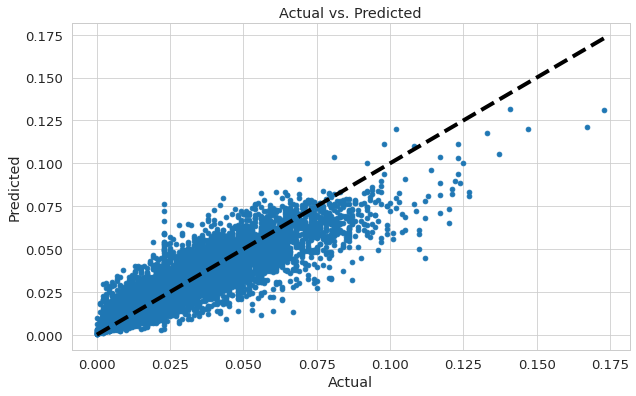

In [60]:
# Plot Actual vs. Predicted
plt.figure(figsize=(10,6))
plt.scatter(y_test, predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()

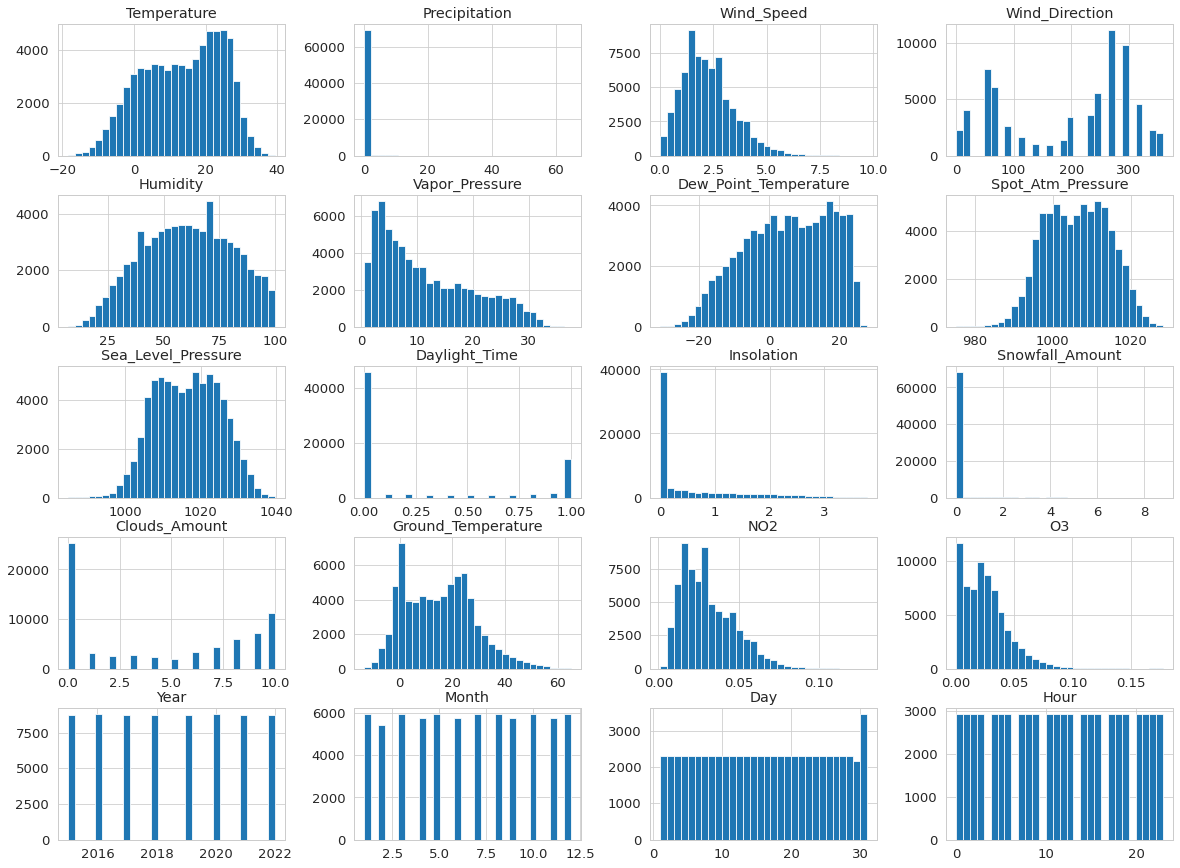

In [61]:
# Histograms for each variable in your dataset
df.hist(bins=30, figsize=(20,15))
plt.show()

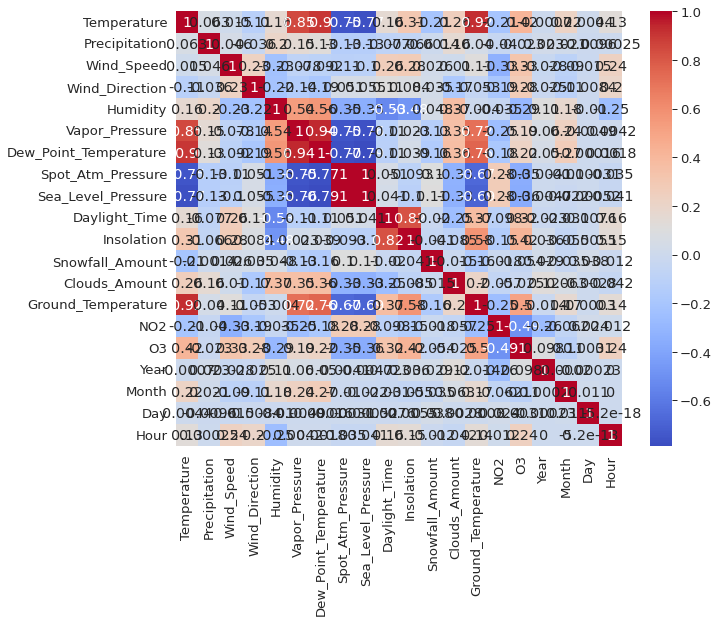

In [62]:
# Heatmap of Correlations
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

ValueError: num must be 1 <= num <= 15, not 16

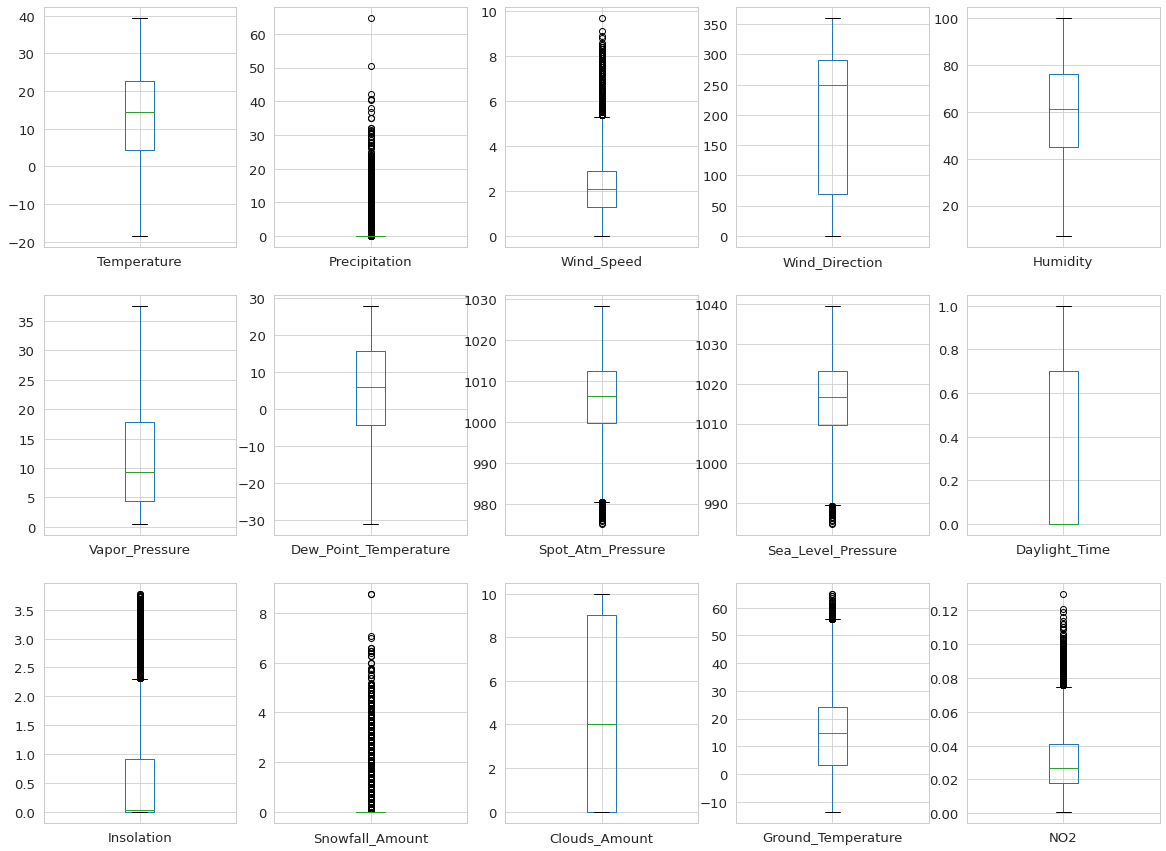

In [63]:
# Box plots for each variable
plt.figure(figsize=(20, 15))
for i, column in enumerate(df.columns, 1):
    plt.subplot(3, 5, i)
    df.boxplot(column)
plt.show()